In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score
import shap
import optuna

from processing_functions import *

random_state = 42

pd.set_option('display.max_rows', 150)
pd.set_option('display.max_colwidth', None)  # Show full strings in columns

X_trainval, y_trainval, X_test, description, description_X_trainval, numerical_vars, cat_vars, binary_vars = load_data()

print("# training+validation obs: ", X_trainval.shape[0])
print("# test obs: ", X_test.shape[0])
print("# features", X_test.shape[1])

/Users/fdd838/Library/CloudStorage/OneDrive-Sky/Desktop/personal/home-credit-default-risk/processing_functions.py:40: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['CODE_GENDER'] = X['CODE_GENDER'].replace({'M': 1, 'F': 0, 'XNA': np.nan})
/Users/fdd838/Library/CloudStorage/OneDrive-Sky/Desktop/personal/home-credit-default-risk/processing_functions.py:40: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['CODE_GENDER'] = X['CODE_GENDER'].replace({'M': 1, 'F': 0, 'XNA': np.nan})


# training+validation obs:  307511
# test obs:  48744
# features 120


In [50]:
print(description[description.Feature=='TARGET'].Description.values[0])
vc = y_trainval.value_counts(dropna=False)
pct = (vc / len(y_trainval)) * 100
display(pd.DataFrame({'count': vc, 'percent': pct.round(2)}))

Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)


,count,percent
TARGET,,
0,282686,91.93
1,24825,8.07


In [51]:
description_X_trainval[description_X_trainval.TYPE=='BINARY']

,Feature,Description,Special,dtype,TYPE,nunique,NaN count,NaN %
0,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,,int64,BINARY,2,0,0.0
2,FLAG_OWN_CAR,Flag if the client owns a car,,int64,BINARY,2,0,0.0
3,FLAG_OWN_REALTY,Flag if client owns a house or flat,,int64,BINARY,2,0,0.0
20,FLAG_MOBIL,"Did client provide mobile phone (1=YES, 0=NO)",,int64,BINARY,2,0,0.0
21,FLAG_EMP_PHONE,"Did client provide work phone (1=YES, 0=NO)",,int64,BINARY,2,0,0.0
22,FLAG_WORK_PHONE,"Did client provide home phone (1=YES, 0=NO)",,int64,BINARY,2,0,0.0
23,FLAG_CONT_MOBILE,"Was mobile phone reachable (1=YES, 0=NO)",,int64,BINARY,2,0,0.0
24,FLAG_PHONE,"Did client provide home phone (1=YES, 0=NO)",,int64,BINARY,2,0,0.0
25,FLAG_EMAIL,"Did client provide email (1=YES, 0=NO)",,int64,BINARY,2,0,0.0
32,REG_REGION_NOT_LIVE_REGION,"Flag if client's permanent address does not match contact address (1=different, 0=same, at region level)",,int64,BINARY,2,0,0.0


In [52]:
display(description_X_trainval.TYPE.value_counts())
description_X_trainval.to_csv("data/preprocessed/description_training_set.csv", index=False)
description_X_trainval#.sort_values(['TYPE', 'NaN count'], ascending=[True, False])

TYPE
NUMERIC        73
BINARY         35
CATEGORICAL    12
Name: count, dtype: int64

,Feature,Description,Special,dtype,TYPE,nunique,NaN count,NaN %
0,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,,int64,BINARY,2,0,0.00
1,CODE_GENDER,Gender of the client,,float64,NUMERIC,2,4,0.00
2,FLAG_OWN_CAR,Flag if the client owns a car,,int64,BINARY,2,0,0.00
3,FLAG_OWN_REALTY,Flag if client owns a house or flat,,int64,BINARY,2,0,0.00
4,CNT_CHILDREN,Number of children the client has,,int64,NUMERIC,15,0,0.00
5,AMT_INCOME_TOTAL,Income of the client,,float64,NUMERIC,2548,0,0.00
6,AMT_CREDIT,Credit amount of the loan,,float64,NUMERIC,5603,0,0.00
7,AMT_ANNUITY,Loan annuity,,float64,NUMERIC,13672,12,0.00
8,AMT_GOODS_PRICE,For consumer loans it is the price of the goods for which the loan is given,,float64,NUMERIC,1002,278,0.09
9,NAME_TYPE_SUITE,Who was accompanying client when he was applying for the loan,,object,CATEGORICAL,7,1292,0.42


In [53]:
for col in cat_vars:
    print(f"{col}: {description[description.Feature==col].Description}")
    vc = X_trainval[col].value_counts(dropna=False)
    pct = (vc / len(X_trainval)) * 100
    display(pd.DataFrame({'count': vc, 'percent': pct.round(2)}))

NAME_TYPE_SUITE: 11    Who was accompanying client when he was applying for the loan
Name: Description, dtype: object


,count,percent
NAME_TYPE_SUITE,,
Unaccompanied,248526,80.82
Family,40149,13.06
"Spouse, partner",11370,3.70
Children,3267,1.06
Other_B,1770,0.58
NaN,1292,0.42
Other_A,866,0.28
Group of people,271,0.09


NAME_INCOME_TYPE: 12    Clients income type (businessman, working, maternity leave,)
Name: Description, dtype: object


,count,percent
NAME_INCOME_TYPE,,
Working,158774,51.63
Commercial associate,71617,23.29
Pensioner,55362,18.00
State servant,21703,7.06
Unemployed,22,0.01
Student,18,0.01
Businessman,10,0.00
Maternity leave,5,0.00


NAME_EDUCATION_TYPE: 13    Level of highest education the client achieved
Name: Description, dtype: object


,count,percent
NAME_EDUCATION_TYPE,,
Secondary / secondary special,218391,71.02
Higher education,74863,24.34
Incomplete higher,10277,3.34
Lower secondary,3816,1.24
Academic degree,164,0.05


NAME_FAMILY_STATUS: 14    Family status of the client
Name: Description, dtype: object


,count,percent
NAME_FAMILY_STATUS,,
Married,196432,63.88
Single / not married,45444,14.78
Civil marriage,29775,9.68
Separated,19770,6.43
Widow,16088,5.23
NaN,2,0.00


NAME_HOUSING_TYPE: 15    What is the housing situation of the client (renting, living with parents, ...)
Name: Description, dtype: object


,count,percent
NAME_HOUSING_TYPE,,
House / apartment,272868,88.73
With parents,14840,4.83
Municipal apartment,11183,3.64
Rented apartment,4881,1.59
Office apartment,2617,0.85
Co-op apartment,1122,0.36


OCCUPATION_TYPE: 28    What kind of occupation does the client have
Name: Description, dtype: object


,count,percent
OCCUPATION_TYPE,,
NaN,96391,31.35
Laborers,55186,17.95
Sales staff,32102,10.44
Core staff,27570,8.97
Managers,21371,6.95
Drivers,18603,6.05
High skill tech staff,11380,3.70
Accountants,9813,3.19
Medicine staff,8537,2.78


WEEKDAY_APPR_PROCESS_START: 32    On which day of the week did the client apply for the loan
Name: Description, dtype: object


,count,percent
WEEKDAY_APPR_PROCESS_START,,
TUESDAY,53901,17.53
WEDNESDAY,51934,16.89
MONDAY,50714,16.49
THURSDAY,50591,16.45
FRIDAY,50338,16.37
SATURDAY,33852,11.01
SUNDAY,16181,5.26


ORGANIZATION_TYPE: 40    Type of organization where client works
Name: Description, dtype: object


,count,percent
ORGANIZATION_TYPE,,
Business Entity Type 3,67992,22.11
NaN,55374,18.01
Self-employed,38412,12.49
Other,16683,5.43
Medicine,11193,3.64
Business Entity Type 2,10553,3.43
Government,10404,3.38
School,8893,2.89
Trade: type 7,7831,2.55


FONDKAPREMONT_MODE: 86    Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor
Name: Description, dtype: object


,count,percent
FONDKAPREMONT_MODE,,
NaN,210295,68.39
reg oper account,73830,24.01
reg oper spec account,12080,3.93
not specified,5687,1.85
org spec account,5619,1.83


HOUSETYPE_MODE: 87    Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor
Name: Description, dtype: object


,count,percent
HOUSETYPE_MODE,,
NaN,154297,50.18
block of flats,150503,48.94
specific housing,1499,0.49
terraced house,1212,0.39


WALLSMATERIAL_MODE: 89    Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor
Name: Description, dtype: object


,count,percent
WALLSMATERIAL_MODE,,
NaN,156341,50.84
Panel,66040,21.48
"Stone, brick",64815,21.08
Block,9253,3.01
Wooden,5362,1.74
Mixed,2296,0.75
Monolithic,1779,0.58
Others,1625,0.53


EMERGENCYSTATE_MODE: 90    Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor
Name: Description, dtype: object


,count,percent
EMERGENCYSTATE_MODE,,
No,159428,51.84
NaN,145755,47.40
Yes,2328,0.76


In [54]:
X_trainval = feature_engineering(X_trainval)
X_test = feature_engineering(X_test)

/Users/fdd838/Library/CloudStorage/OneDrive-Sky/Desktop/personal/home-credit-default-risk/processing_functions.py:64: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['NAME_EDUCATION_TYPE_ORDINAL'] = X['NAME_EDUCATION_TYPE'].replace(education_order).astype('int64')
/Users/fdd838/Library/CloudStorage/OneDrive-Sky/Desktop/personal/home-credit-default-risk/processing_functions.py:64: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  X['NAME_EDUCATION_TYPE_ORDINAL'] = X['NAME_EDUCATION_TYPE'].replace(education_order).astype('int64')
/Users/fdd838/Library/C

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=random_state, stratify=y_trainval)

scale_weight = np.sum(y_train == 0) / np.sum(y_train == 1)
print(f"Class Imbalance Ratio (scale_pos_weight): {scale_weight:.2f}")

FIXED_PARAMS =  {
    # Fixed parameters
    "booster": "gbtree",
    "tree_method": "hist",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "device": "cuda",
    "verbosity": 0,
    'seed': random_state,
    'max_cat_to_onehot': 1
}

INITIAL_PARAMS = {
    'scale_pos_weight': scale_weight,
    'max_depth': 6,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 1,  # L1 regularization
    'reg_lambda': 1,  # L2 regularization
    'min_child_weight': 1,
}

params = INITIAL_PARAMS.copy()
params.update(FIXED_PARAMS)

Class Imbalance Ratio (scale_pos_weight): 11.39


Best Iteration: 117
Best CV AUC: 0.76023


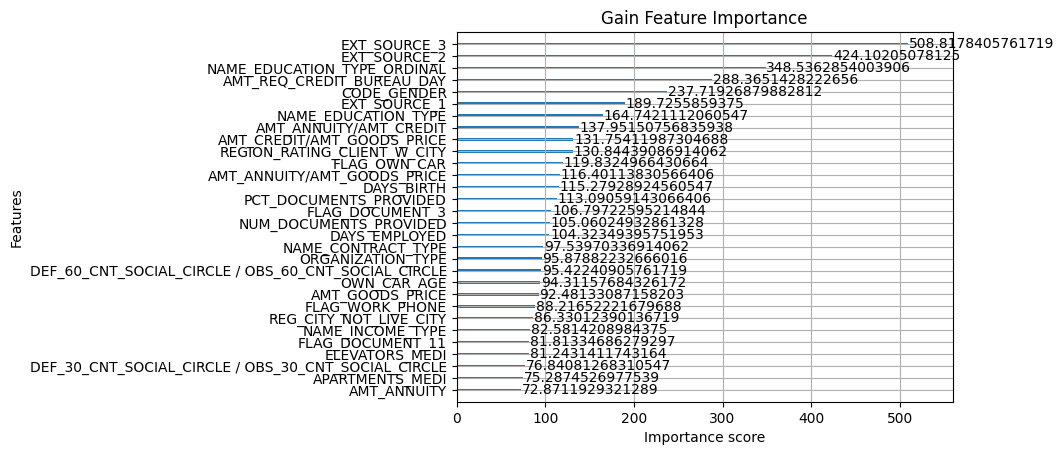

/Users/fdd838/Library/CloudStorage/OneDrive-Sky/Desktop/personal/home-credit-default-risk/processing_functions.py:161: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_val)


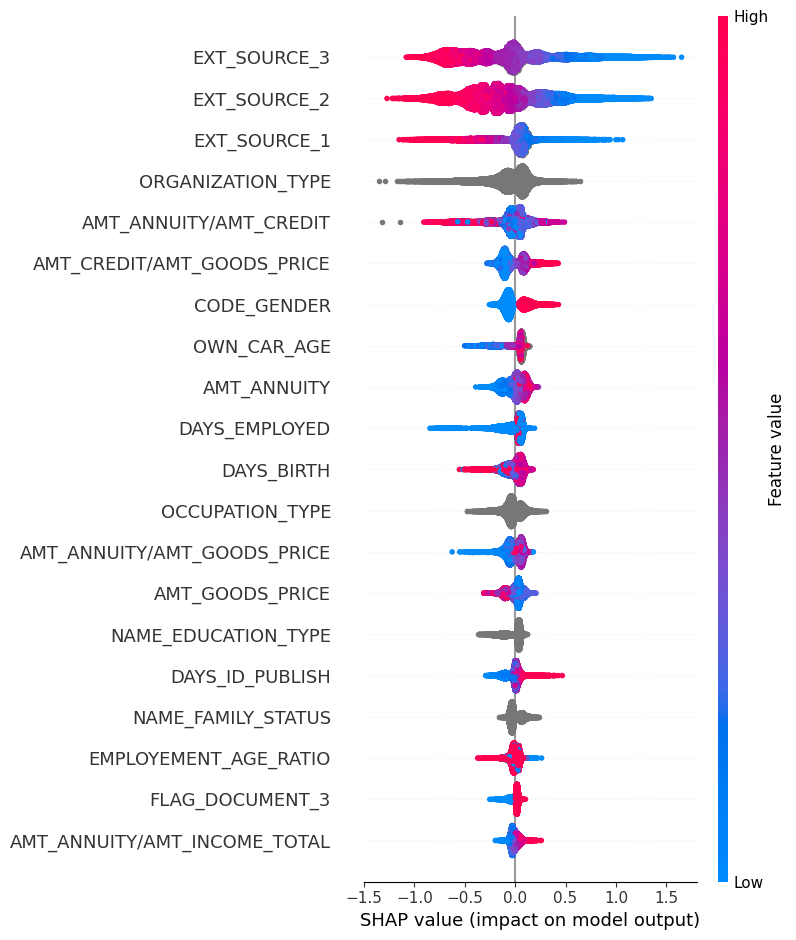

In [56]:
importance, shap_values, model = model_training_and_evaluation(
    params=params, 
    X_trainval=X_trainval, 
    y_trainval=y_trainval,
    X_train=X_train, 
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    X_test=X_test, 
    submission_name="submission1", 
    seed=random_state,
    nfold=5, 
    num_boost_round=1000, 
    early_stopping_rounds=10,
    stratified=True, 
    metrics="auc",
)

In [57]:
#get_ordered_importance(importance)
shap_importance = get_ordered_shap_importance(X_val, shap_values)
shap_importance

,Feature,shap_importance,%shap_importance,CUMSUM %shap_importance
0,EXT_SOURCE_3,0.384775,14.313480,14.313480
1,EXT_SOURCE_2,0.340997,12.684944,26.998425
2,EXT_SOURCE_1,0.167419,6.227930,33.226357
3,ORGANIZATION_TYPE,0.131492,4.891440,38.117798
4,AMT_ANNUITY/AMT_CREDIT,0.119563,4.447705,42.565502
5,AMT_CREDIT/AMT_GOODS_PRICE,0.104438,3.885052,46.450554
6,CODE_GENDER,0.090802,3.377801,49.828354
7,OWN_CAR_AGE,0.088829,3.304413,53.132767
8,AMT_ANNUITY,0.076334,2.839600,55.972366
9,DAYS_EMPLOYED,0.069161,2.572767,58.545132


Best Iteration: 124
Best CV AUC: 0.76028


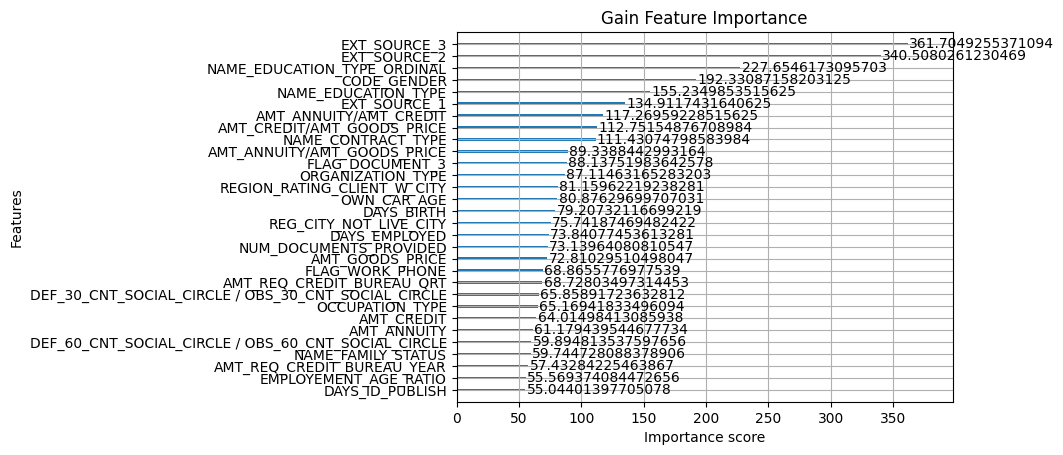

/Users/fdd838/Library/CloudStorage/OneDrive-Sky/Desktop/personal/home-credit-default-risk/processing_functions.py:161: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_val)


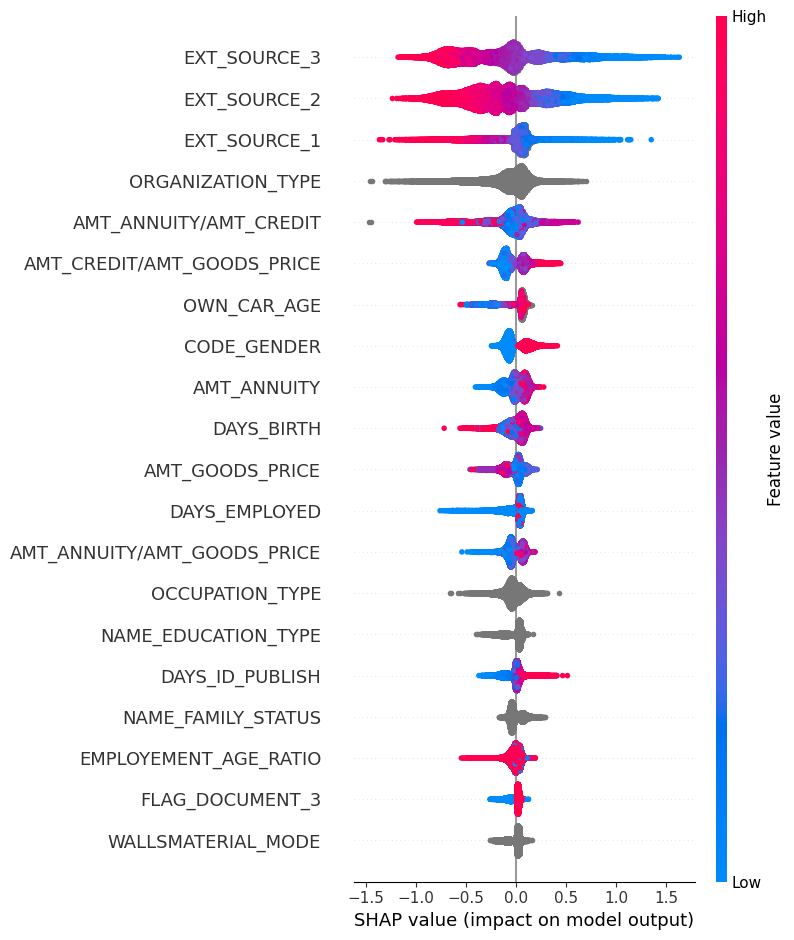

In [58]:
to_keep = shap_importance.iloc[:37].Feature.tolist()
importance, shap_values, model = model_training_and_evaluation(
    params=params, 
    X_trainval=X_trainval[to_keep], 
    y_trainval=y_trainval,
    X_train=X_train[to_keep], 
    y_train=y_train,
    X_val=X_val[to_keep],
    y_val=y_val,
    X_test=X_test[to_keep], 
    submission_name="submission2", 
    seed=random_state,
    nfold=5, 
    num_boost_round=1000, 
    early_stopping_rounds=10,
    stratified=True, 
    metrics="auc",
)

In [ ]:
def objective(trial):

    optuna_params = {
        # Tuned parameters
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "eta": trial.suggest_float("eta", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 100.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 100.0, log=True),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 5.0, 15.0),
        "gamma": trial.suggest_float("gamma", 0.0, 2.0),
    }
    optuna_params.update(FIXED_PARAMS)

    n_estimators = 500

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=trial.number) # use trial.number for different splits per trial
    aucs = []

    for fold, (train_idx, val_idx) in enumerate(cv.split(X_train[to_keep], y_train)):
        X_train_optuna, X_val_optuna = X_train[to_keep].iloc[train_idx], X_train[to_keep].iloc[val_idx]
        y_train_optuna, y_val_optuna = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = xgb.XGBClassifier(
            **optuna_params,
            n_estimators=n_estimators,
            random_state=random_state,
            early_stopping_rounds=None, #disable early stopping for optuna
            n_jobs=-1,
            enable_categorical=True
        )

        model.fit(
            X_train_optuna,
            y_train_optuna,
            eval_set=[(X_val_optuna, y_val_optuna)],
            verbose=False,
        )

        preds = model.predict_proba(X_val_optuna)[:, 1]
        auc = roc_auc_score(y_val_optuna, preds)
        aucs.append(auc)

    return np.mean(aucs)


study = optuna.create_study(
    study_name="optuna_study_0",
    storage="sqlite:///optuna.db",
    load_if_exists=True,
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=random_state),
    pruner=optuna.pruners.MedianPruner(n_startup_trials=10, n_warmup_steps=20),
)
study.enqueue_trial(INITIAL_PARAMS)
study.optimize(objective, n_trials=50, timeout=None, show_progress_bar=True, n_jobs=-1)

print("Best CV AUC:", study.best_value)
print("Best hyperparameters:")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")

[I 2025-12-28 17:17:40,732] A new study created in memory with name: no-name-78be5b34-4c2d-4559-b886-0c3aee65120d
[I 2025-12-28 17:18:06,830] Trial 0 finished with value: 0.7591136127643836 and parameters: {'max_depth': 6, 'eta': 0.03574712922600244, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'min_child_weight': 1, 'scale_pos_weight': np.float64(11.38710976837865), 'gamma': 0.0}. Best is trial 0 with value: 0.7591136127643836.
[I 2025-12-28 17:18:36,898] Trial 1 finished with value: 0.7316398433538459 and parameters: {'max_depth': 8, 'eta': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'reg_alpha': 0.042070539502879374, 'reg_lambda': 0.017073967431528128, 'min_child_weight': 9, 'scale_pos_weight': 11.011150117432088, 'gamma': 1.416145155592091}. Best is trial 0 with value: 0.7591136127643836.
[I 2025-12-28 17:18:55,785] Trial 2 finished with value: 0.7555356300418989 and parameters: {'max_depth': 3, 'et

Best CV AUC: 0.7680783642546999
Best hyperparameters:
  max_depth: 6
  eta: 0.045579925802196344
  subsample: 0.9739862516733353
  colsample_bytree: 0.7944684216868048
  reg_alpha: 72.25572052085609
  reg_lambda: 3.045094681655215
  min_child_weight: 7
  scale_pos_weight: 13.23257997855362
  gamma: 1.797717626456765


In [ ]:
optuna.visualization.plot_param_importances(study)

ImportError: Tried to import 'plotly' but failed. Please make sure that the package is installed correctly to use this feature. Actual error: No module named 'plotly'.

Best Iteration: 475
Best CV AUC: 0.76987


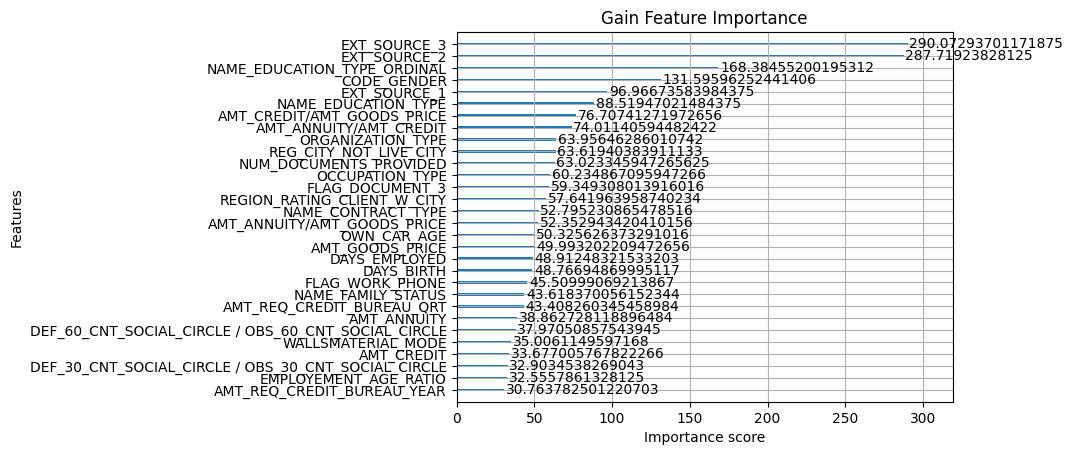

/Users/fdd838/Library/CloudStorage/OneDrive-Sky/Desktop/personal/home-credit-default-risk/processing_functions.py:161: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_val)


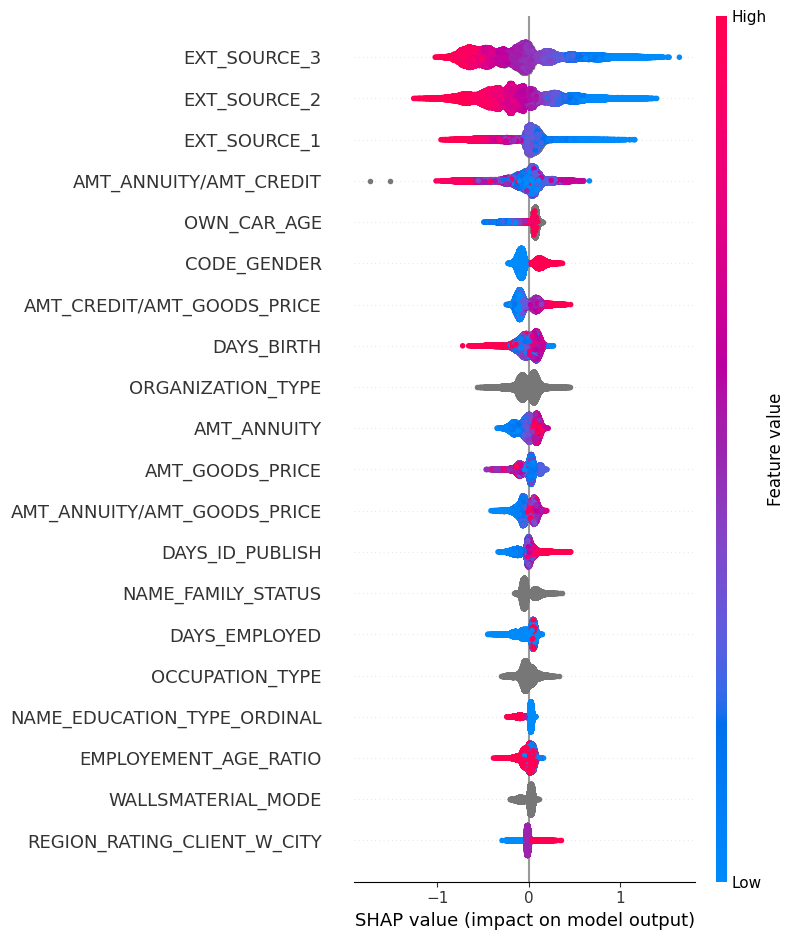

In [ ]:
## BACKUP
# Best CV AUC: 0.7680783642546999
# Best hyperparameters:
#   max_depth: 6
#   eta: 0.045579925802196344
#   subsample: 0.9739862516733353
#   colsample_bytree: 0.7944684216868048
#   reg_alpha: 72.25572052085609
#   reg_lambda: 3.045094681655215
#   min_child_weight: 7
#   scale_pos_weight: 13.23257997855362
#   gamma: 1.797717626456765

params = study.best_params
params.update(FIXED_PARAMS)

importance, shap_values, model = model_training_and_evaluation(
    params=params, 
    X_trainval=X_trainval[to_keep], 
    y_trainval=y_trainval,
    X_train=X_train[to_keep], 
    y_train=y_train,
    X_val=X_val[to_keep],
    y_val=y_val,
    X_test=X_test[to_keep], 
    submission_name="submission3", 
    seed=random_state,
    nfold=5, 
    num_boost_round=1000, 
    early_stopping_rounds=10,
    stratified=True, 
    metrics="auc",
)